In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Extended Kalman Filter #

The EKF handles non-linear problems by making $H$ and $A$ linear locally.

However, the EKF is not globally convergent anymore, it is only locally convergent.

Equations:

$\left\{
    \begin{array}{ll}
        Y = H.X + R \\
        \hat{X}_{k+1}^+ = A.\hat{X}_k + B_k.u_k
    \end{array}
\right.
$
$\Rightarrow$
$\left\{
    \begin{array}{ll}
        Y = h(X,R) \\
        \hat{X}_{k+1}^+ = f(\hat{X}_k)
    \end{array}
\right.
$

$X = 
\begin{pmatrix}
\dot{\alpha} \\
\alpha \\
b \\
\end{pmatrix}$
 and 
$Y = 
\begin{pmatrix}
    \dot{\alpha} \\
    a \\
\end{pmatrix}$

$Y$: measure

$X$: real state vector

$R$: Measure error

$H$: Observation matrix - $h$: Observation function (non-linear)

$A$: Prediction matrix - $f$: Observation function (non-linear)


In this example, $\dot{\alpha}$ is the angular speed, $\alpha$ is the angular position and $b$ is the gyroscope bias.

The measure vector contains the angular speed $v$ measured from the gyroscope, and the acceleration $a$ measured from the accelerometer. $T_e$ is the sampling step.

In [20]:
# Generate real data
T_max = 10 # seconds
T_step = 0.1
bias = 5
s1_noise = 0.1    # gyroscope var
s2_noise = 0.1    # accelerometre var
e_angular_speed = 10.0
e_position = 0.0
e_bias = 2.0
g = 9.806

T = np.arange(0, T_max, T_step)
X_real = np.zeros((3, len(T)))

# Angular speed
X_real[0,:] = -g * np.sin(2 * np.pi * T)
# Angular position
for i in range(1,len(T)):
    X_real[1, i] = X_real[1, i-1] + T_step * X_real[0, i-1]
# Bias
# X_real[2,:] = np.ones((1, len(T))) * bias
X_real[2,:] = np.exp(T/bias) * bias


In [21]:
# Generate measures
Y = np.zeros((2, X_real.shape[1])) #+ np.random.normal(0, 1, X_real.shape)
# Y[0,:] = X_real[0,:] + X_real[2,:] + np.random.normal(0, s1_noise, X_real[0,:].shape)
# Y[1,:] = 10 * np.pi * np.cos(2 * np.pi * T) 

Y[0,:] = X_real[0,:] + X_real[2,:] + np.random.normal(0, s1_noise, X_real[0,:].shape)
Y[1,:] = -2 * np.pi * g * np.cos(2 * np.pi * T) + np.random.normal(0, s2_noise, X_real[0,:].shape)

**Model:**

$X_{k+1} = A.X_k + B_k.u_k$

$\begin{pmatrix} \dot{\alpha} \\ \alpha \\ b \\ \end{pmatrix}_{k+1}=
\begin{pmatrix} 1 & 0 & 0 \\ T_e & 1 & 0 \\ 0 & 0 & 1 \\ \end{pmatrix}.
\begin{pmatrix} \dot{\alpha} \\ \alpha_M \\ v \\ \end{pmatrix}_{k}
 + B_k.u_k$
 
$B_k$: Control matrix.

$u_k$: Control vector

Here we consider $B_k$ and $u_k$ as null as we make no control over the system.


**Measure noise covariance matrix:**

$R=\begin{pmatrix} \sigma_1^2 & 0 \\ 0 & \sigma_2^2 \\ \end{pmatrix}$

**Command noise covariance matrix:** (system modelization error)

$Q=\begin{pmatrix} \epsilon_\dot{\alpha} & 0 & 0 \\ 0 & \epsilon_\alpha & 0 \\ 0 & 0 & \epsilon_b \end{pmatrix}$

**Prediction:**

$\hat{X}_{k+1}^+ = A.\hat{X}_k + B_k.u_k$

$P_k^+=A.P_k.A^T+Q$

**Update:**

$K_{k+1}=P_k^+.h_{k+1}^T.(R_{k+1}+h_{k+1}.P_k^+.h_{k+1}^T)^{-1}$

$P_{k+1}=(I-K_{k+1}.h_{k+1}).P_k^+$

$\hat{X}_{k+1}=\hat{X}_k^++K_{k+1}.(y_{k+1}-h(\hat{X}_k^+,0))$


**Linearization:**

To locally linearize $H_k$ and $A$, we consider the Jacobian matrices.

$h = 
\left\{
    \begin{array}{ll}
        v = \dot{\alpha} + b + b_1 \\
        a = -g.\sin(\alpha) + b_2
    \end{array}
\right.
$

$H = \frac{\partial{h}}{\partial{X}} =
\begin{pmatrix}
    \frac{\partial{v}}{\partial{\dot{\alpha}}} & \frac{\partial{v}}{\partial{\alpha}} & \frac{\partial{v}}{\partial{b}} \\
    \frac{\partial{a}}{\partial{\dot{\alpha}}} & \frac{\partial{a}}{\partial{\alpha}} & \frac{\partial{a}}{\partial{b}}
\end{pmatrix} = 
\begin{pmatrix}
    1 & 0 & 1 \\
    0 & -g.\cos(\alpha) & 0
\end{pmatrix}
$


$f = 
\left\{
    \begin{array}{ll}
        \dot{\alpha}_{k+1} = \dot{\alpha}_k \\
        \alpha_{k+1} = \alpha_k + T_e.\dot{\alpha}_k \\
        b_{k+1} = b_k
    \end{array}
\right.
$

$A = \frac{\partial{f}}{\partial{X}} =
\begin{pmatrix}
    1 & 0 & 0 \\
    T_e & 1 & 0 \\
    0 & 0 & 1
\end{pmatrix}$

$A$ is the same because $f$ is linear.

In [22]:
# Kalman filter variables
X_pred = np.zeros((X_real.shape[0], X_real.shape[1] + 1))
X_est = np.zeros(X_real.shape)
X_est[:,0] = X_real[:,0]

# Covariance matrix of the estamed state
P = np.zeros((3, 3))
P_pred = np.zeros((3, 3))    # prediction of P

# Observation matrix
H = np.array([[1, 0, 1], [0, -g * np.cos(X_est[1,0]), 0]])

def h(x, b_noise = [0.0, 0.0]):
    global g
    res = []
    res.append(x[0] + x[2] + b_noise[0])
    res.append(-g * np.sin(x[1]) + b_noise[1])
    return np.array(res)
    

# Sensor noise
R = np.array([[s1_noise**2, 0], [0, s2_noise**2]])
                  
# Model
A = np.array([[1, 0, 0], [T_step, 1, 0], [0, 0, 1]])
                  
# Modele error
Q = np.array([[e_angular_speed, 0, 0], [0, e_position, 0], [0, 0, e_bias]])

# Main loop
for i, t in enumerate(T):
    if i == 0:
        continue
    # A is linear so it does not need to be updated
    # Prediction
    X_pred[:,i] = A.dot(X_est[:,i-1])
    P_pred = A.dot(P).dot(A.T) + Q
    
    # We update H with the predicted state
    H = np.array([[1, 0, 1], [0, -g * np.cos(X_pred[1,i]), 0]])
    
    # Update
    K = P_pred.dot(H.T).dot(np.linalg.inv(R + H.dot(P_pred).dot(H.T)))
    P = (np.identity(3) - K.dot(H)).dot(P_pred)
    X_est[:,i] = X_pred[:,i] + K.dot(Y[:,i] - h(X_pred[:,i]))

print("OK")
                  

OK


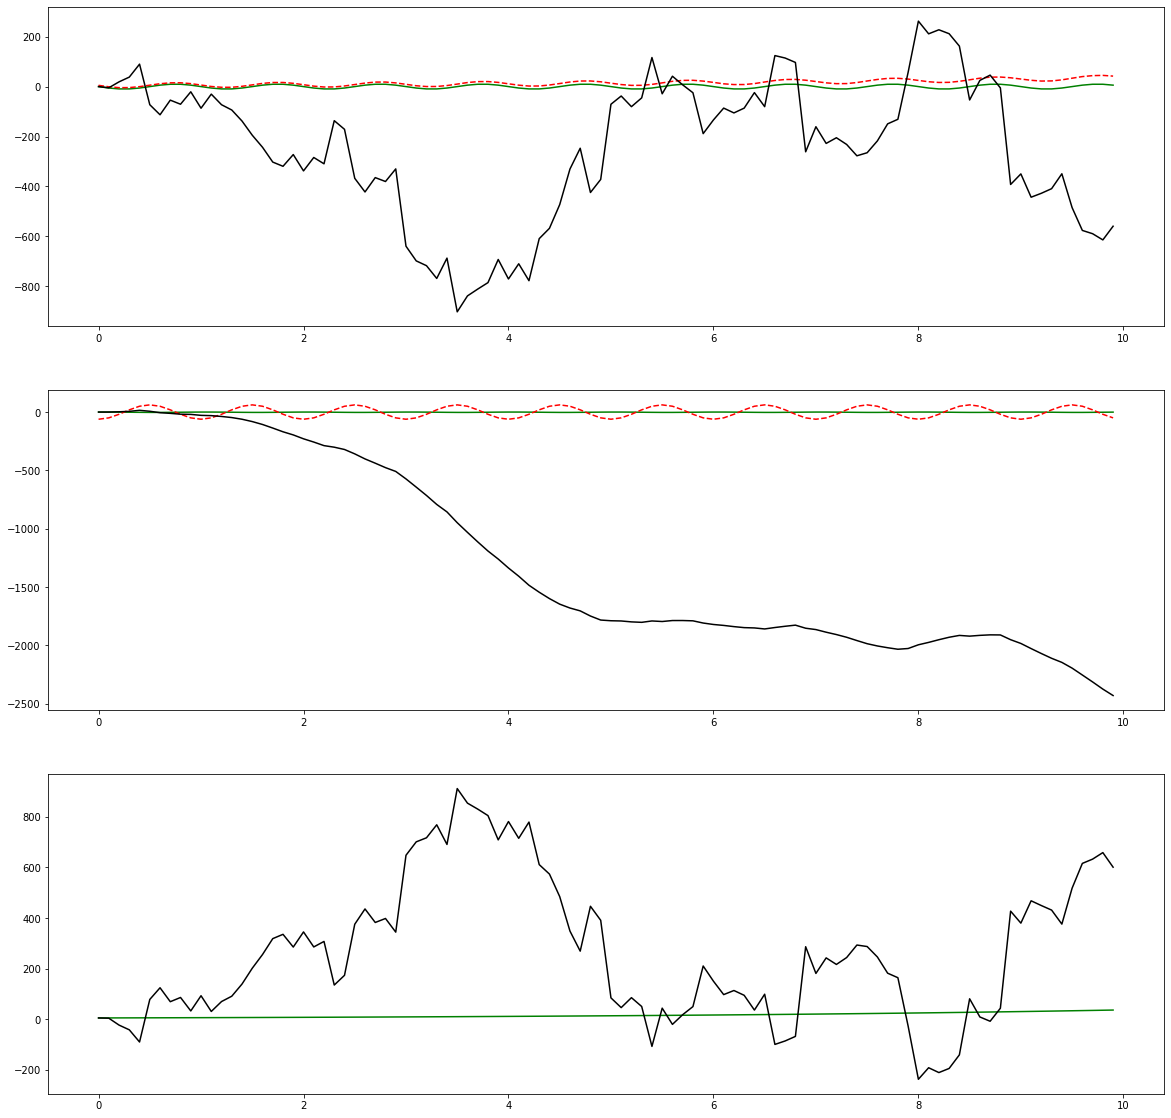

In [23]:
plt.rcParams["figure.figsize"] = (20, 20)

# Plot angular speed
plt.subplot(3,1,1)
plt.plot(T, X_real[0,:], 'g')
plt.plot(T, Y[0,:], 'r--')
plt.plot(T, X_est[0,:], 'k')

# Plot angular position
plt.subplot(3,1,2)
plt.plot(T, X_real[1,:], 'g')
plt.plot(T, Y[1,:], 'r--')
plt.plot(T, X_est[1,:], 'k')

# Plot bias
plt.subplot(3,1,3)
plt.plot(T, X_real[2,:], 'g')
# plt.plot(T, Y[2,:], 'r--')
plt.plot(T, X_est[2,:], 'k')

plt.show()